<a href="https://colab.research.google.com/github/kskaran94/Sepsis_Identification/blob/master/EDA_and_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Libraries imported**

In [0]:
from google.colab import files
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn_pandas import CategoricalImputer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

In [2]:
uploaded = files.upload()



Saving train.psv.zip to train.psv.zip


In [3]:
!unzip /content/train.psv.zip

Archive:  /content/train.psv.zip
  inflating: train.psv               
   creating: __MACOSX/
  inflating: __MACOSX/._train.psv    


### Read Data

In [4]:
train = pd.read_csv('/content/train.psv', sep = '|')
train.shape

(1169865, 41)

In [5]:
train.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

### Distribution of Dependent Variable

In [6]:
train['SepsisLabel'].value_counts()

0    1147309
1      22556
Name: SepsisLabel, dtype: int64

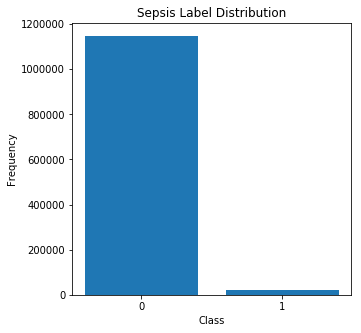

In [7]:
rcParams['figure.figsize'] = 5, 5

plt.bar(train['SepsisLabel'].value_counts().index,
        train['SepsisLabel'].value_counts())
plt.xticks([0,1])
plt.xlabel('Class')
plt.title('Sepsis Label Distribution')
_ = plt.ylabel('Frequency')

As we can see from the plot, it is a case of severe class imbalance . There are multiple methods that we could try to balance it (Over sampling or Undersampling) or even proceed without balancing but change the evaluation metric to average precision or roc_auc_sore

### Check For null in Features/ Independent variables

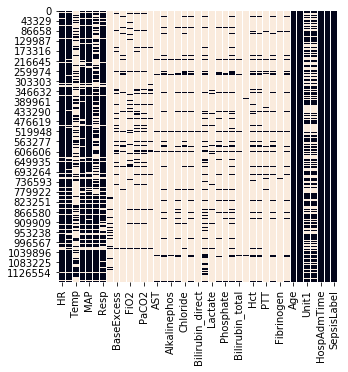

In [8]:
sns.heatmap(train.isnull(), cbar=False)


In [9]:
missing = (train.isnull().sum() / train.shape[0]) * 100
missing

HR                   9.193368
O2Sat               12.764977
Temp                66.119510
SBP                 14.842567
MAP                 11.739303
DBP                 37.084963
Resp                13.524979
EtCO2               97.509713
BaseExcess          92.881999
HCO3                94.504409
FiO2                89.680006
pH                  91.532271
PaCO2               93.353336
SaO2                96.047407
AST                 98.426229
BUN                 92.697875
Alkalinephos        98.449565
Calcium             94.432093
Chloride            94.177277
Creatinine          93.721754
Bilirubin_direct    99.824339
Glucose             84.521462
Lactate             97.074192
Magnesium           93.188958
Phosphate           95.633941
Potassium           90.172798
Bilirubin_total     98.604967
TroponinI           99.323170
Hct                 90.153907
Hgb                 92.124390
PTT                 96.416424
WBC                 93.222295
Fibrinogen          99.306501
Platelets 

We see that most of the columns have 90% + missing data. There are multiple ways of dealing with it. To establish a concrete baseline, I have decided to remove features with 90 % or more missing data. 

Text(0.5, 1.0, 'Percentage of missing data in each feature')

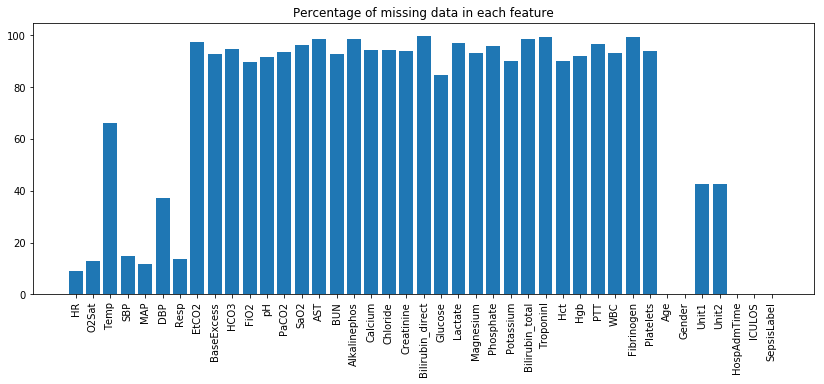

In [10]:
rcParams['figure.figsize'] = 14, 5
_ = plt.bar(missing.index, missing)
_ = plt.xticks(missing.index, rotation=90)

plt.title("Percentage of missing data in each feature")


In [11]:
selected_cols = list(missing[missing < 90].index)
selected_cols

['HR',
 'O2Sat',
 'Temp',
 'SBP',
 'MAP',
 'DBP',
 'Resp',
 'FiO2',
 'Glucose',
 'Age',
 'Gender',
 'Unit1',
 'Unit2',
 'HospAdmTime',
 'ICULOS',
 'SepsisLabel']

In [12]:
filter_train = train[selected_cols]
filter_train.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,FiO2,Glucose,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,118.0,99.5,34.17,72.0,47.5,39.5,14.0,1.0,NaN,41.26,1,NaN,NaN,-0.26,3,0
1,147.0,100.0,NaN,124.0,92.5,75.0,18.0,1.0,190.0,41.26,1,NaN,NaN,-0.26,4,0
2,141.0,100.0,34.80,98.5,69.5,56.5,18.0,NaN,220.5,41.26,1,NaN,NaN,-0.26,5,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,197.0,41.26,1,NaN,NaN,-0.26,6,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,230.0,41.26,1,NaN,NaN,-0.26,7,0


### Univariate plots

In [0]:
categorical = filter_train.dtypes == object
categorical['Unit1'] = True
categorical['Unit2'] = True
categorical['Gender'] = True


In [14]:
cat_vars = list(categorical[categorical].index)
cont_vars = list(categorical[~categorical].index)
cont_vars.pop(-1)


'SepsisLabel'

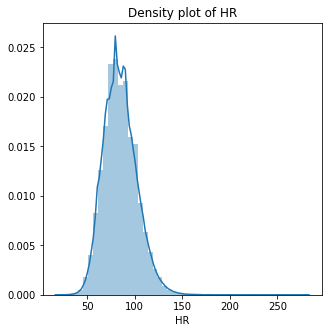

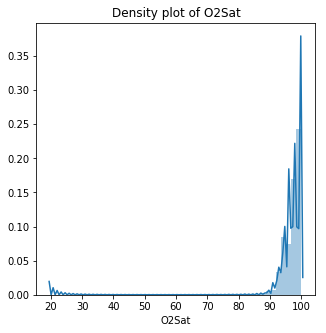

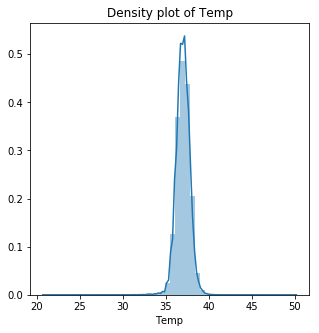

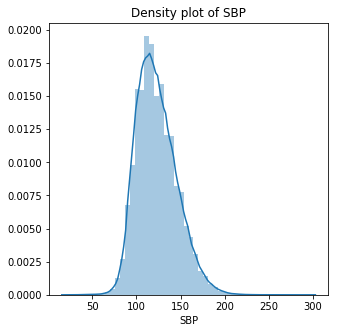

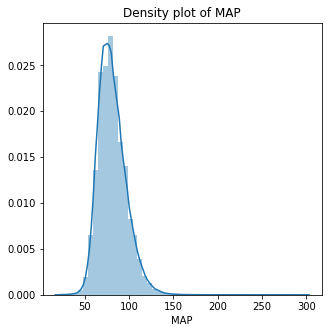

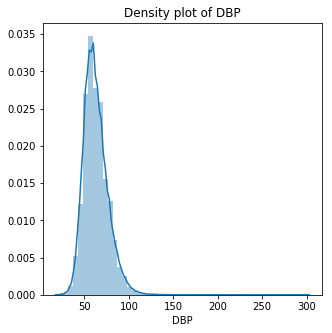

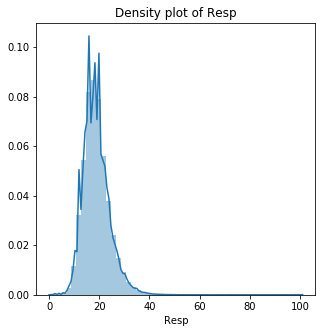

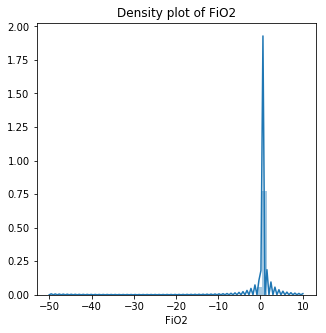

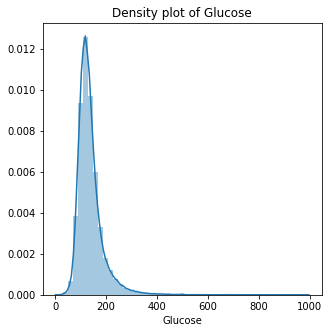

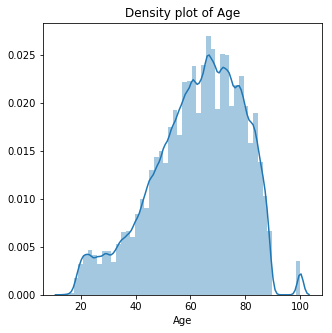

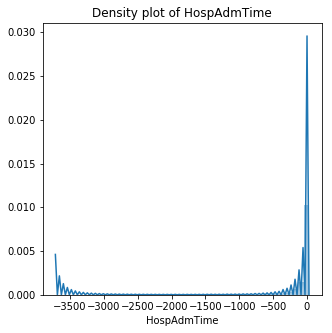

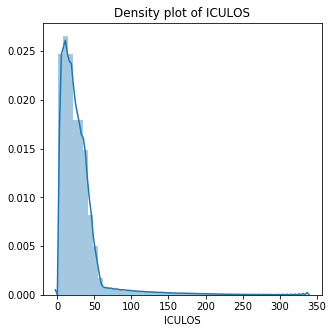

In [15]:
rcParams['figure.figsize'] = 5, 5
for i,var in enumerate(cont_vars):
    plt.figure(i)
    plt.title("Density plot of " + str(var))
    sns.distplot(filter_train[var].dropna(), axlabel=var);

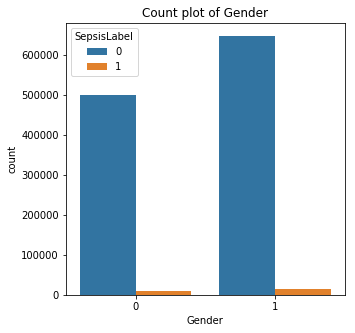

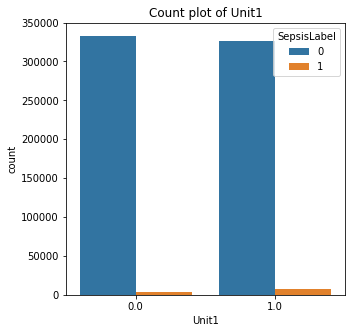

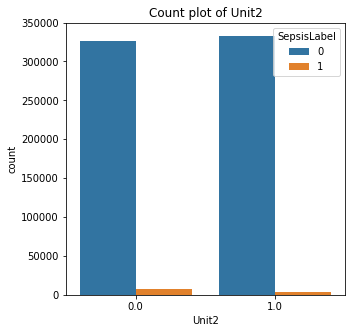

In [0]:
for i,var in enumerate(cat_vars):
    plt.figure(i)
    plt.title("Count plot of " + str(var))
    sns.countplot(filter_train[var].dropna(), hue='SepsisLabel', data= filter_train);

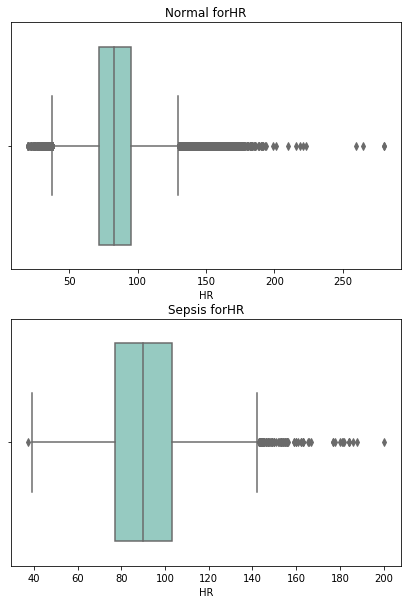

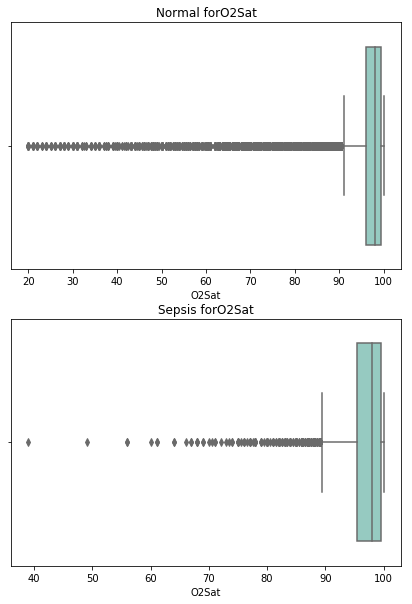

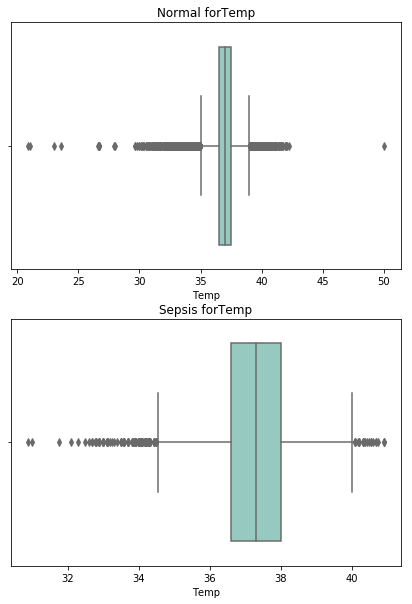

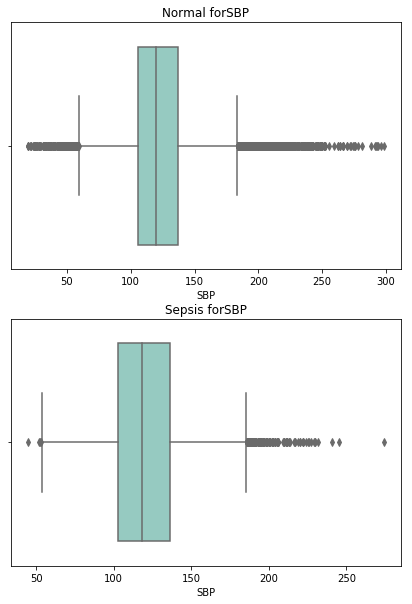

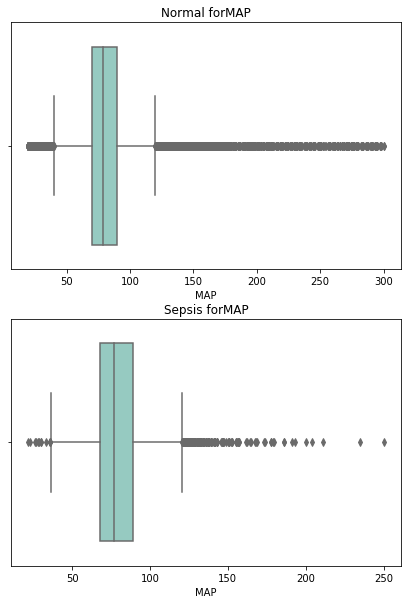

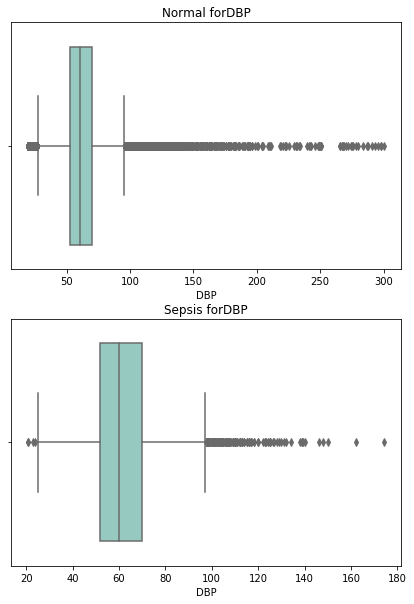

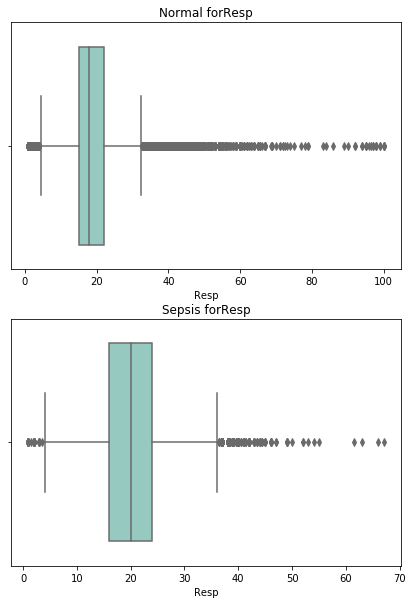

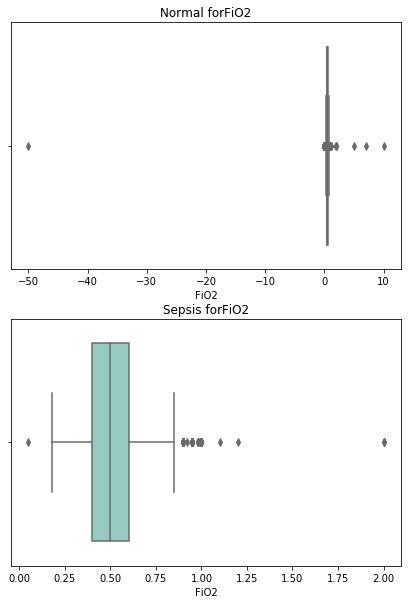

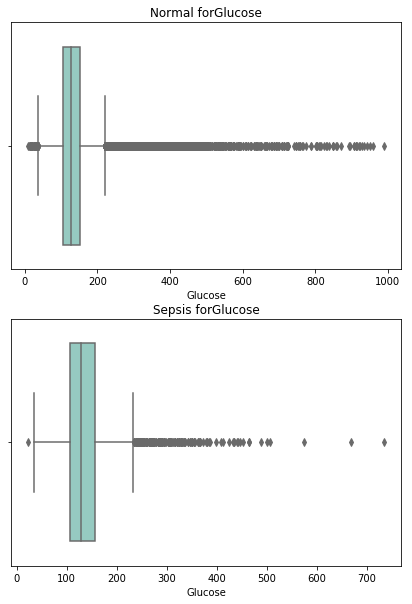

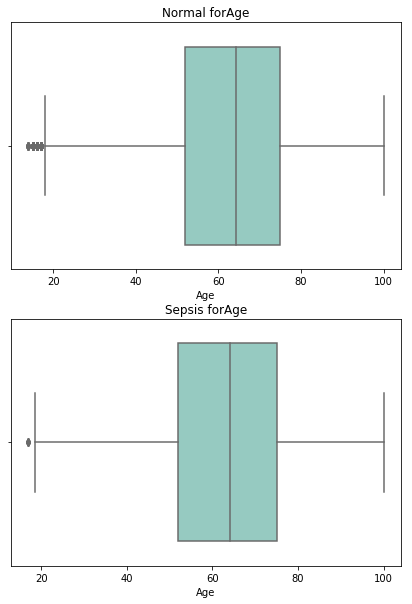

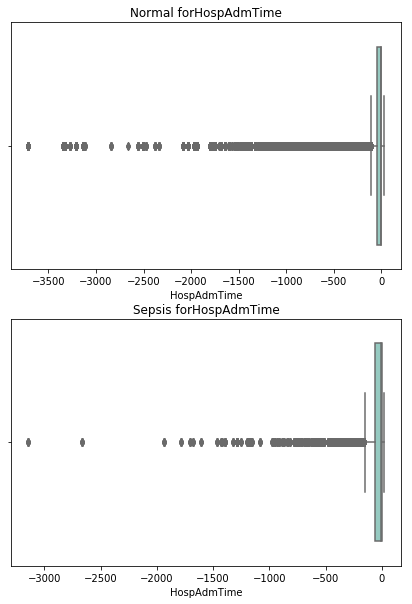

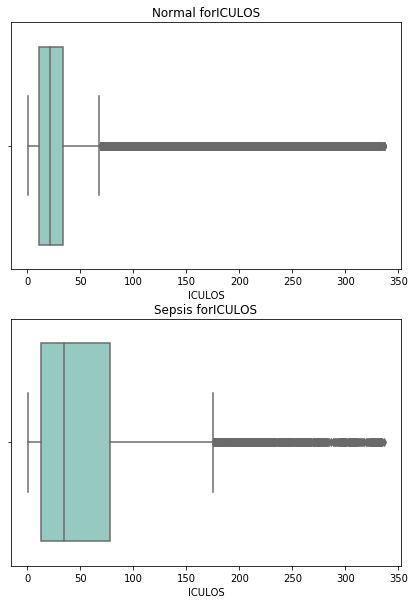

In [63]:
for i,var in enumerate(cont_vars):
    temp = filter_train[[var,'SepsisLabel']].dropna()
    temp1 = temp[temp['SepsisLabel']==0]
    temp2 = temp[temp['SepsisLabel']==1]
    fig, ax = plt.subplots(2, 1, figsize=(7, 10))

    sns.boxplot(temp1[var], ax=ax[0], palette='Set3')
    sns.boxplot(temp2[var], ax=ax[1], palette='Set3')
    ax[0].set_title("Normal for " + var)
    ax[1].set_title("Sepsis for " + var)



## **Baseline**

The Features which are used for basleline. No Feature engineering has been done yet 

In [0]:
features = cont_vars + cat_vars
features

['HR',
 'O2Sat',
 'Temp',
 'SBP',
 'MAP',
 'DBP',
 'Resp',
 'FiO2',
 'Glucose',
 'Age',
 'HospAdmTime',
 'ICULOS',
 'Gender',
 'Unit1',
 'Unit2']

In [0]:
X_train = filter_train[features]
y_train = filter_train['SepsisLabel']

In [0]:
categorical = X_train.dtypes == object
categorical['Unit1'] = True
categorical['Unit2'] = True
categorical['Gender'] = True

In [0]:
cont_scale_pipeline = make_pipeline(SimpleImputer(strategy = "median"), 
                                    StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy = "constant", 
                                           fill_value = 999), 
                             OneHotEncoder(handle_unknown="ignore"))
preprocess_trans_scale = make_column_transformer((cont_scale_pipeline, 
                                                  ~categorical), 
                                                 (cat_pipeline, categorical))

In [0]:
logistic_pipe_scale = make_pipeline(preprocess_trans_scale, 
                                    LogisticRegression(solver='lbfgs') )
rf_pipe_scale = make_pipeline(preprocess_trans_scale, RandomForestClassifier())
svc_pipe_scale = make_pipeline(preprocess_trans_scale, SVC())
gb_pipe_scale = make_pipeline(preprocess_trans_scale, GradientBoostingClassifier())
dt_pipe_scale = make_pipeline(preprocess_trans_scale, DecisionTreeClassifier() )
gmm_pipe_scale = make_pipeline(preprocess_trans_scale, GaussianMixture(n_components=2))
mlp_pipe_scale = make_pipeline(preprocess_trans_scale, MLPClassifier() )


In [0]:
scores_logistic_pipe_scale = cross_validate(logistic_pipe_scale, X_train, 
                                             y_train, 
                                             cv=StratifiedKFold(3, shuffle=True)
                                             ,scoring=["average_precision", 
                                                       "roc_auc", "precision", 
                                                       "recall"])



scores_rf_pipe_scale = cross_validate(rf_pipe_scale, X_train, 
                                             y_train, 
                                             cv=StratifiedKFold(3, shuffle=True)
                                             ,scoring=["average_precision", 
                                                       "roc_auc", "precision", 
                                                       "recall"])



scores_gb_pipe_scale = cross_validate(gb_pipe_scale, X_train, 
                                             y_train, 
                                             cv=StratifiedKFold(3, shuffle=True)
                                             ,scoring=["average_precision", 
                                                       "roc_auc", "precision", 
                                                       "recall"])



scores_dt_pipe_scale = cross_validate(dt_pipe_scale, X_train, 
                                             y_train, 
                                             cv=StratifiedKFold(3, shuffle=True)
                                             ,scoring=["average_precision", 
                                                       "roc_auc", "precision", 
                                                       "recall"])


scores_gmm_pipe_scale = cross_validate(gmm_pipe_scale, X_train, 
                                             y_train, 
                                             cv=StratifiedKFold(3, shuffle=True)
                                             ,scoring=["average_precision", 
                                                       "roc_auc", "precision", 
                                                       "recall"])

scores_mlp_pipe_scale = cross_validate(mlp_pipe_scale, X_train, 
                                             y_train, 
                                             cv=StratifiedKFold(3, shuffle=True)
                                             ,scoring=["average_precision", 
                                                       "roc_auc", "precision", 
                                                       "recall"])

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
log_df = pd.DataFrame(scores_logistic_pipe_scale)
log_df['model'] = 'LogisticRegression'

dt_df = pd.DataFrame(scores_dt_pipe_scale)
dt_df['model'] = 'DecisionTree'

gb_df = pd.DataFrame(scores_gb_pipe_scale)
gb_df['model'] = 'GradientBoosting'

rf_df = pd.DataFrame(scores_rf_pipe_scale)
rf_df['model'] = 'RandomForest'

gmm_df = pd.DataFrame(scores_gmm_pipe_scale)
gmm_df['model'] = 'GMM'

mlp_df = pd.DataFrame(scores_mlp_pipe_scale)
mlp_df['model'] = 'MLP'




results = pd.concat([log_df, dt_df, gb_df, rf_df, gmm_df, mlp_df])

In [0]:
results

,fit_time,score_time,test_average_precision,test_roc_auc,test_precision,test_recall,model
0,7.611157,2.017487,0.071857,0.727672,0.191781,0.001862,LogisticRegression
1,8.142756,1.995413,0.073176,0.727376,0.225490,0.003059,LogisticRegression
2,5.138180,2.000983,0.070523,0.722542,0.244444,0.002926,LogisticRegression
0,20.830284,2.095555,0.137285,0.680937,0.332473,0.376779,DecisionTree
1,22.150067,2.105724,0.128715,0.672709,0.323020,0.359622,DecisionTree
2,20.925736,2.096886,0.110077,0.659345,0.290483,0.334530,DecisionTree
0,200.444403,4.612183,0.117531,0.785900,0.723404,0.009044,GradientBoosting
1,207.409091,4.555136,0.116421,0.790547,0.537037,0.007714,GradientBoosting
2,198.840454,4.586021,0.120006,0.792486,0.674157,0.007981,GradientBoosting
0,32.893491,5.748398,0.300345,0.828571,0.850455,0.086980,RandomForest
